In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load dataset
ratings = pd.read_csv("../data/ratings.csv")
movies = pd.read_csv("../data/movies.csv")
tags = pd.read_csv("../data/tags.csv")

In [ ]:
print("="*35)
print("THỐNG KÊ DỮ LIỆU".center(35))
print("="*35)
print(f"Số người dùng:         {ratings['userId'].nunique():,}")
print(f"Số đánh giá:           {ratings.shape[0]:,}")
print(f"Tổng số phim:          {movies.shape[0]:,}")
print(f"Phim được gắn nhãn:    {tags['movieId'].nunique():,}")
print(f"Phim được xếp hạng:    {ratings['movieId'].nunique():,}")
print("="*35)


          THỐNG KÊ DỮ LIỆU         
Số người dùng:         162,541
Số đánh giá:           25,000,095
Tổng số phim:          62,423
Phim được gắn nhãn:    45,251
Phim được xếp hạng:    59,047


# Phân tích khám phá dữ liệu (EDA)

**Biểu đồ tần suất theo điểm đánh giá**

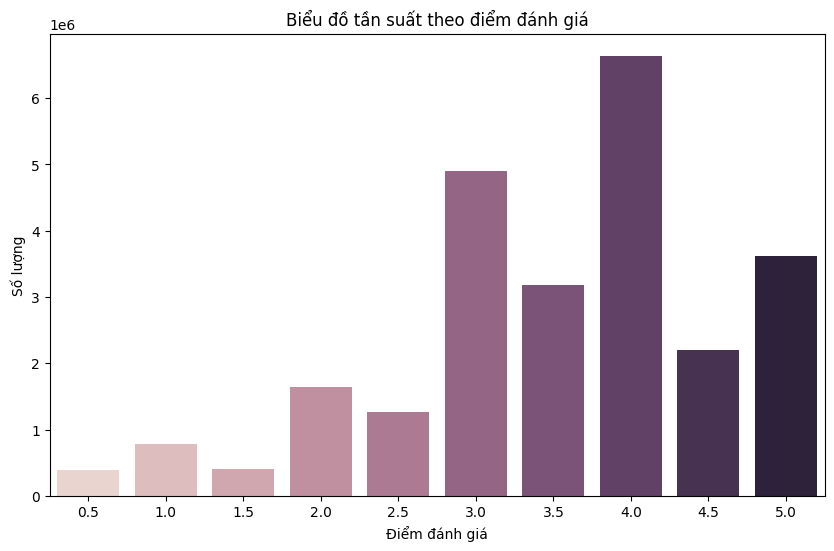

In [6]:
# Vẽ biểu đồ 
plt.figure(figsize=(10, 6))
sns.countplot(data=ratings, x='rating', hue='rating', legend=False)
plt.title('Biểu đồ tần suất theo điểm đánh giá')
plt.xlabel('Điểm đánh giá')
plt.ylabel('Số lượng')
plt.show()

**Nhận xét:**
- Phần lớn các đánh giá tập trung ở mức cao, từ 3.0 đến 5.0.
- Rating 4.0 là phổ biến nhất, rating 3.0 đứng thứ hai về tần suất, rating 5.0 có số lượng đáng kể.
- Các ratings thấp (0.5, 1.0, 1.5) có tần suất thấp nhất.

***Kết luận:*** Dữ liệu cho thấy xu hướng đánh giá tích cực, với phần lớn người dùng hài lòng (ratings từ 3.5 trở lên). Các đánh giá tiêu cực (dưới 2.5) chiếm một tỷ lệ rất nhỏ.

## Phân tích theo phim

**Top 20 bộ phim có số lượt đánh giá nhiều nhất**

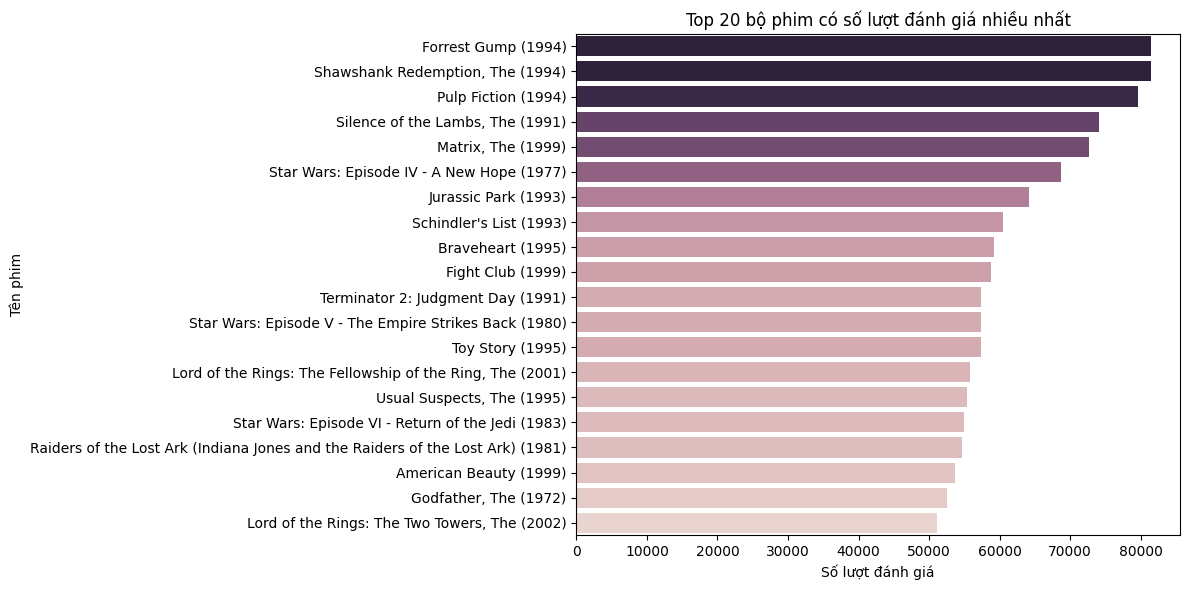

In [12]:
# Lấy danh sách 20 bộ phim có số lượt đánh giá nhiều nhất
top_movies = ratings['movieId'].value_counts().head(20)
# Tạo DataFrame 
top_movies = pd.DataFrame({'movieId': top_movies.index, 'num_ratings': top_movies.values})
# Gộp dữ liệu với bảng 'movies' để lấy tên phim
top_movies = top_movies.merge(movies[['movieId', 'title']], on='movieId')

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.barplot(y='title', x='num_ratings', hue='num_ratings', data=top_movies, legend=False)
plt.title('Top 20 bộ phim có số lượt đánh giá nhiều nhất')
plt.xlabel('Số lượt đánh giá')
plt.ylabel('Tên phim')
plt.tight_layout()
plt.show()

**Nhận xét:**
- Đa số các phim có lượt đánh giá cao là phim thập niên 90, phản ánh độ phổ biến của chúng trong bộ dữ liệu.
- Biểu đồ cho thấy các phim top đầu có lượt đánh giá nhiều hơn đáng kể với các bộ phim còn lại.

**Top 20 bộ phim có điểm trung bình cao nhất**

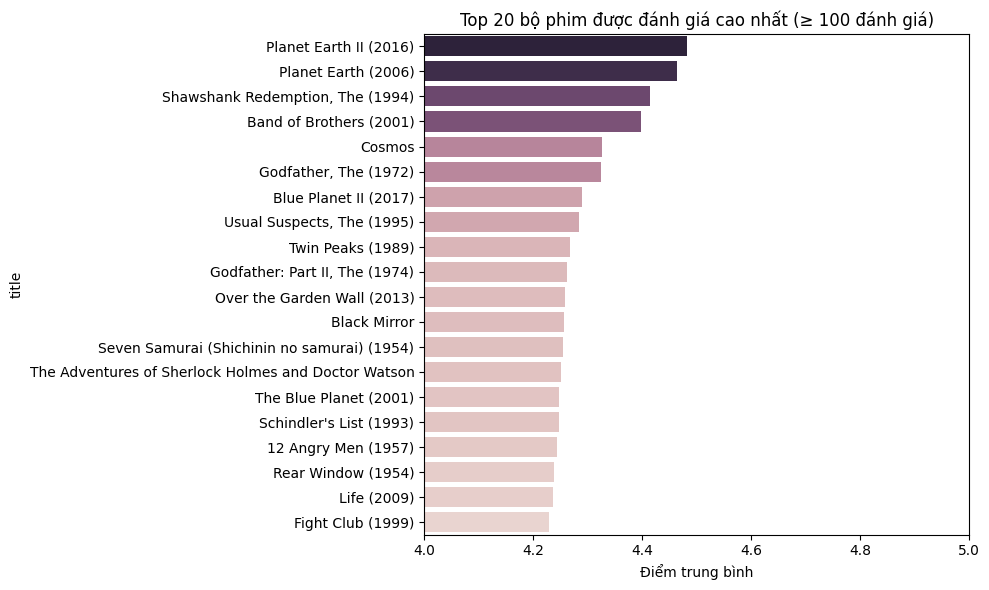

In [13]:
# Tính điểm trung bình và số lượt đánh giá cho từng phim
movie_stats = ratings.groupby('movieId').agg(
    avg_rating=('rating', 'mean'),
    rating_count=('rating', 'count')
).reset_index()

# Lọc các bộ phim có ít nhất 100 đánh giá
popular_movies = movie_stats[movie_stats['rating_count'] >= 100]
# Lấy 20 bộ phim có điểm trung bình cao nhất
top_rated = popular_movies.sort_values(by='avg_rating', ascending=False).head(20)
# Gộp với bảng 'movies' để lấy title của phim
top_rated = top_rated.merge(movies[['movieId', 'title']], on='movieId')

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x='avg_rating', y='title', hue='avg_rating', data=top_rated, legend=False)
plt.title('Top 20 bộ phim được đánh giá cao nhất (≥ 100 đánh giá)')
plt.xlabel('Điểm trung bình')
plt.xlim(4, 5)
plt.tight_layout()
plt.show()

**Nhận xét:**
- Thời gian phát hành không là yếu tố quyết định chất lượng phim (thời kì nào cũng có phim chất lượng cao).
- Một số bộ phim xuất hiện trong cả hai danh sách (Shawshank Redemption, Godfather, Fight Club), chứng tỏ chúng vừa phổ biến vừa có chất lượng.

***Kết luận:*** Biểu đồ cho thấy sự đa dạng về thể loại và thời kỳ.

## Phân tích theo thể loại

**Biểu đồ phân phối của thể loại phim**

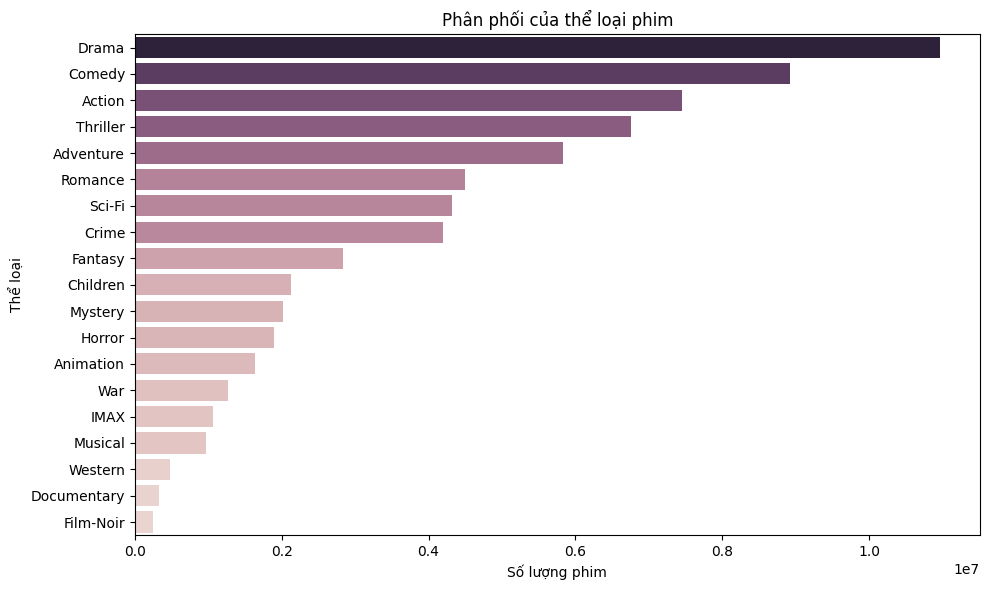

In [14]:
# Thống kê số lượng các genres
merged = ratings.merge(movies, on='movieId')
merged = merged[merged['genres'] != '(no genres listed)']
merged['genres'] = merged['genres'].str.split('|')
exploded = merged.explode('genres')

# Đếm số lượng phim theo từng thể loại
genre_counts = exploded['genres'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(data=genre_counts, x='count', y='genre', hue='count', legend=False)
plt.title('Phân phối của thể loại phim')
plt.xlabel('Số lượng phim')
plt.ylabel('Thể loại')
plt.tight_layout()
plt.show()

**Nhận xét:**

- Biểu đồ thể hiện 19 thể loại phim, cho thấy dữ liệu có độ bao phủ thể loại khá rộng.

- Phân phối thể loại không đồng đều, tập trung vào các thể loại phổ biến nhiều như Drama, Comedy và Action. Ngược lại, các thể loại ít xuất hiện hơn thường là những loại ít được khai thác.

## Phân tích theo thời gian

**Biểu đồ cho thấy số lượng đánh giá theo năm**

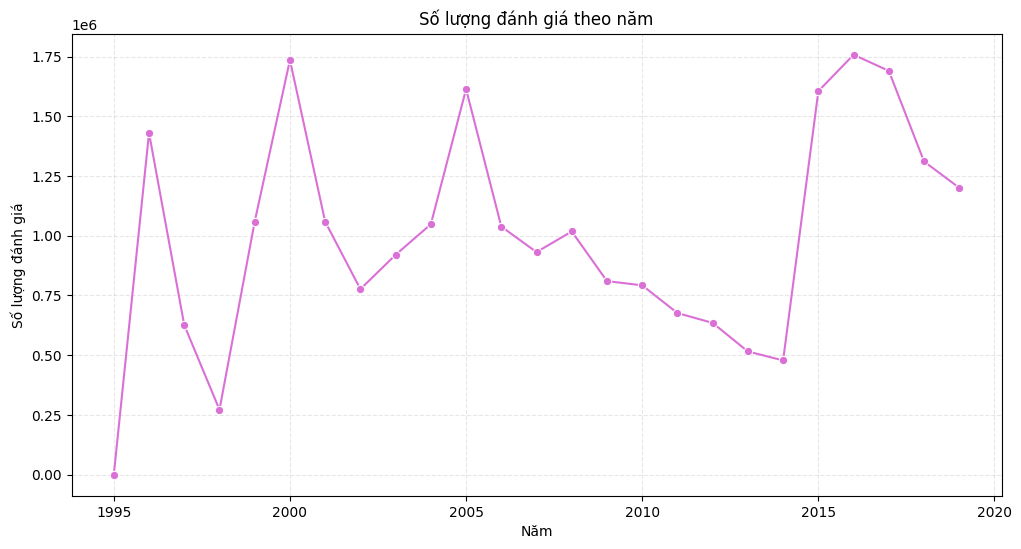

In [15]:
# Chuyển cột 'timestamp' sang kiểu datetime và lấy năm
ratings['year'] = pd.to_datetime(ratings['timestamp'], unit='s').dt.year
# Đếm số đánh giá theo từng năm
ratings_by_year = ratings['year'].value_counts().sort_index()

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.lineplot(x=ratings_by_year.index, y=ratings_by_year.values, marker='o', color='orchid')
plt.title('Số lượng đánh giá theo năm')
plt.xlabel('Năm')
plt.ylabel('Số lượng đánh giá')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

**Nhận xét:**

- Số lượng đánh giá biến động mạnh qua các năm, không theo xu hướng tuyến tính rõ ràng.

- Giai đoạn tương tác cao đột biến thể hiện rõ ràng ở 2 đỉnh vào năm 2000 và năm 2016. Giai đoạn 2010–2014 cho thấy mức sụt giảm kéo dài và chạm đáy. Sau 2015 thì dữ liệu phục hồi mạnh.

**Kết luận:** Phân phối đánh giá của người dùng theo thời gian là không ổn định.


**Biểu đồ heatmap: số lượt đánh giá theo năm và tháng**

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


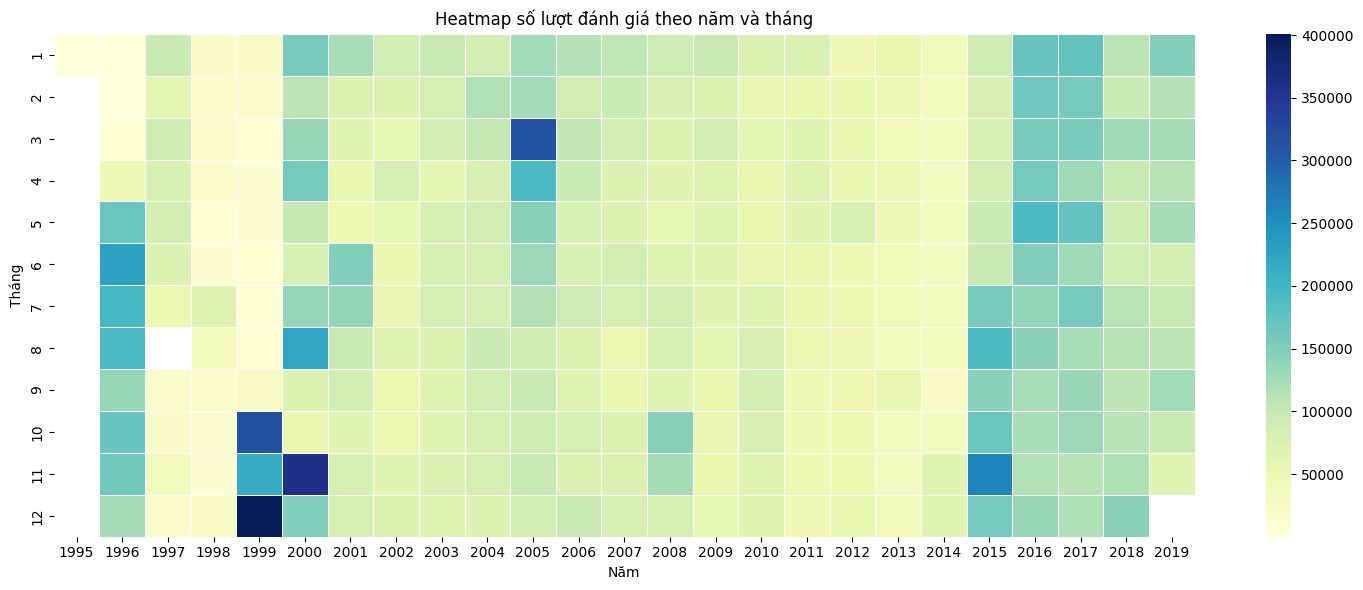

In [14]:
# Chuyển cột 'timestamp' sang kiểu datetime và lấy theo tháng (Year-Month)
ratings['year_month'] = pd.to_datetime(ratings['timestamp'], unit='s').dt.to_period('M')
# Đếm số lượt đánh giá theo tháng và năm
ratings_heatmap = ratings.groupby(ratings['year_month']).size().reset_index(name='count')
ratings_heatmap['year'] = ratings_heatmap['year_month'].dt.year
ratings_heatmap['month'] = ratings_heatmap['year_month'].dt.month

# Tạo bảng pivot với tháng là index và năm là cột
pivot_table = ratings_heatmap.pivot(index='month', columns='year', values='count')

# Vẽ biểu đồ
plt.figure(figsize=(15, 6))
sns.heatmap(pivot_table, cmap='YlGnBu', linewidths=0.5, annot=False)
plt.title('Heatmap số lượt đánh giá theo năm và tháng')
plt.xlabel('Năm')
plt.ylabel('Tháng')
plt.tight_layout()
plt.show()

**Nhận xét:**

- Lượt đánh giá phân bố không đồng đều theo tháng và năm, thể hiện tính thời điểm rõ rệt.

- Một số "hotspot" nổi bật: cuối năm 1999, đầu 2005, và cuối 2015 — cho thấy các đợt tương tác bùng nổ ngắn hạn. 

- Giai đoạn 2010–2014 nhìn chung khá "lặng sóng", màu nhạt đồng đều – phản ánh mức độ tương tác thấp kéo dài.

**Kết luận:** Heatmap giúp phát hiện và quan sát rõ rành hơn các giai đoạn đột biến số lượt đánh giá của người dùng.

# Tiền xử lý dữ liệu (Pre-processing data)

In [3]:
# Kiểm tra ratings hợp lệ (0.5 đến 5.0)
if (ratings['rating'] < 0.5).any() or (ratings['rating'] > 5.0).any():
    print("Warning: Invalid rating values detected.")

In [4]:
# Tính số lượng người dùng, phim và tổng số lượt đánh giá
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
n_ratings = len(ratings)

# Tính độ thưa (sparsity) của ma trận ratings
sparsity = 1 - n_ratings / (n_users * n_movies)
print(f"\nĐộ thưa của ma trận: {sparsity:.4f} ({n_ratings} ratings / {n_users * n_movies} possible ratings)")


Độ thưa của ma trận: 0.9974 (25000095 ratings / 9597558427 possible ratings)


In [5]:
# Nối bảng 'ratings' với 'movies' để lấy tiêu đề phim
df = pd.merge(ratings, movies, on='movieId')

# Truncated SVD

In [8]:
def truncated_svd(X, n_components=30):
    """
    Tính Truncated SVD (Singular Value Decomposition) cho ma trận thưa X.

    Tham số:
        X: Ma trận thưa (users x movies)
        n_components: Số lượng thành phần chính (rank giảm chiều)
    
    Các bước thực hiện:
        1. Tính X.T @ X (movies x movies)
        2. Phân tích eigen: lấy top k các trị riêng (eigenvalues) và vector riêng (eigenvectors) lớn nhất
        3. Tính các giá trị kỳ dị (singular values) bằng căn bậc hai của eigenvalues
        4. Tính ma trận U = X @ V / Sigma
        5. Dựng lại ma trận xấp xỉ: X ~ U * Sigma * V^T

    Trả về:
        - X_approx: Ma trận xấp xỉ gốc với rank thấp hơn
    """

    # Bước 1: X.T @ X
    C = X.T.dot(X)

    # Bước 2: Phân tích eigen (chỉ lấy top k)
    eigenvalues, eigenvectors = eigsh(C, k=n_components, which='LM')

    # Bước 3: Sắp xếp các trị riêng theo thứ tự giảm dần
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Bước 4: Tính singular values từ eigenvalues
    Sigma = np.sqrt(eigenvalues)

    # Bước 5: Tính ma trận U
    U = X.dot(eigenvectors)
    U = U / Sigma[np.newaxis, :]

    Vt = eigenvectors.T

    # Step 6: Dựng lại ma trận xấp xỉ
    X_approx = U @ np.diag(Sigma) @ Vt

    return X_approx

In [20]:
# from scipy.sparse import coo_matrix

# def svd_baseline_predict(ratings_df, user_enc, movie_enc, k=50):
#     """
#     Dự đoán rating bằng phương pháp SVD có chuẩn hóa (phiên bản đơn giản của Iterative SVD) theo người dùng.

#     Tham số:
#         ratings_df: DataFrame chứa các cột ['user_idx', 'movie_idx', 'rating']
#         user_enc, movie_enc: LabelEncoder đã fit
#         k: Số lượng thành phần ẩn (rank giảm chiều)
        
#     Các bước thực hiện:
#         1. Khởi tạo ma trận rating rời rạc từ dữ liệu.
#         2. Tính trung bình ratings theo từng hàng (user).
#         3. Mean-center ma trận bằng cách trừ trung bình từng user.
#         4. Áp dụng Truncated SVD để xấp xỉ ma trận chuẩn hóa.
#         5. Cộng lại trung bình user để khôi phục thang điểm ban đầu.

#     Trả về:
#         R_hat: Ma trận dự đoán (users x movies)
#         R: Ma trận gốc ở dạng sparse
#         row_means: Giá trị trung bình ratings theo từng user
#     """

#     # Kiểm tra tính hợp lệ của dữ liệu đầu vào
#     required_columns = ['user_idx', 'movie_idx', 'rating']
#     if not all(col in ratings_df.columns for col in required_columns):
#         raise ValueError(f"ratings_df must contain columns: {required_columns}")
#     if ratings_df[required_columns].isnull().any().any():
#         raise ValueError("ratings_df contains NaN values.")

#     ratings_df = ratings_df.copy()

#     n_users = len(user_enc.classes_)
#     n_movies = len(movie_enc.classes_)

#     if k > min(n_users, n_movies):
#         raise ValueError(f"k={k} is too large. Must be <= {min(n_users, n_movies)}")

#     # Bước 1: Tạo sparse matrix từ ratings gốc
#     row = ratings_df['user_idx'].values
#     col = ratings_df['movie_idx'].values
#     data = ratings_df['rating'].values
#     R = coo_matrix((data, (row, col)), shape=(n_users, n_movies))

#     #  Bước 2: Tính trung bình ratings theo từng user (row_means)
#     row_sums = np.array(R.sum(axis=1)).flatten()
#     row_counts = np.array((R != 0).sum(axis=1)).flatten()
#     row_means = np.zeros(n_users)
#     mask = row_counts > 0
#     row_means[mask] = row_sums[mask] / row_counts[mask]

#     # Bước 3: Chuẩn hóa ma trận bằng cách trừ trung bình mỗi user (Mean-center)
#     R_centered = R.copy()
#     R_centered.data -= row_means[R_centered.row]

#     # Bước 4: Áp dụng Truncated SVD lên ma trận chuẩn hóa
#     U, S, Vt = truncated_svd(R_centered, n_components=k)

#     # Bước 5: Khôi phục lại ma trận dự đoán ban đầu
#     R_hat_centered = U @ np.diag(S) @ Vt
#     R_hat = R_hat_centered + row_means[:, np.newaxis]

#     return R_hat, R, row_means

# Chia tập dữ liệu và Đánh giá

In [9]:
# Lọc 1000 người dùng đánh giá nhiều nhất
sample_users = df['userId'].value_counts().head(1000).index
sample_df = df[df['userId'].isin(sample_users)].copy()

# Mã hóa userId và title thành chỉ số để xây dựng ma trận
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
sample_df['user_idx'] = user_encoder.fit_transform(sample_df['userId'])
sample_df['movie_idx'] = movie_encoder.fit_transform(sample_df['title'])

# Chia dữ liệu thành tập huấn luyện và kiểm tra (train và test)
train_df, test_df = train_test_split(sample_df, test_size=0.3, random_state=42)

# Tạo ma trận thưa từ tập train (users x movies)
train_matrix = csr_matrix((train_df['rating'], (train_df['user_idx'], train_df['movie_idx'])),
                          shape=(sample_df['user_idx'].nunique(), sample_df['movie_idx'].nunique()))

# Áp dụng Truncated SVD để giảm chiều
X_approx = truncated_svd(train_matrix, n_components=30)

In [10]:
def evaluate_metric(df, X_approx):
    """
    Đánh giá chất lượng dự đoán của ma trận xấp xỉ so với ratings gốc.

    Tham số:
        df : Chứa các cột ['user_idx', 'movie_idx', 'rating']
        X_approx : Ma trận xấp xỉ

    Trả về:
        rmse : Root Mean Squared Error
        mae  : Mean Absolute Error
    """
    predictions, actuals = [], []

    for _, row in df.iterrows():
        u, m = row['user_idx'], row['movie_idx']
        # Chỉ xét những chỉ số hợp lệ (trong vùng của X_approx)
        if u < X_approx.shape[0] and m < X_approx.shape[1]:
            predictions.append(X_approx[u, m])
            actuals.append(row['rating'])

    # Tính sai số
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    return rmse, mae

# Đánh giá trên tập huấn luyện (train)
train_rmse, train_mae = evaluate_metric(train_df, X_approx)
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")

# Đánh giá trên tập kiểm tra (test)
test_rmse, test_mae = evaluate_metric(test_df, X_approx)
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Train RMSE: 2.1261
Train MAE: 1.8688
Test RMSE: 2.3079
Test MAE: 2.0664


# Gợi ý phim

In [22]:
def recommend_movies(user_id, X_approx, user_encoder, movie_encoder, movies_df, ratings_df, top_n=10):
    '''
    Gợi ý top_n phim cho user_id dựa trên SVD
    - user_id: ID gốc của người dùng
    - user_encoder, movie_encoder: LabelEncoder
    - user_factors, movie_factors: output từ Truncated SVD
    - movies_df: DataFrame chứa thông tin phim
    - top_n: số phim gợi ý
    '''
        
    # Lấy user_Id   
    user_idx = user_encoder.transform([user_id])[0]
    
    # Tính điểm đánh giá dự đoán
    scores = X_approx[user_idx]
    
    # Lấy top n phim theo điểm đánh giá dự đoán
    movie_titles = movie_encoder.inverse_transform(np.argsort(scores)[::-1][:top_n])

    # Tạo dict ánh xạ tiêu đề phim và điểm dự đoán
    score_dict = dict(zip(movie_titles, scores[np.argsort(scores)[::-1][:top_n]]))

    # Lọc các phim trong movies_df
    recommended_movies = movies_df[movies_df['title'].isin(movie_titles)].copy()
    recommended_movies['score'] = recommended_movies['title'].map(score_dict)

    # Thêm rating thực tế nếu có
    ratings_user = ratings_df[ratings_df['userId'] == user_id][['movieId', 'rating']]
    recommended_movies = recommended_movies.merge(ratings_user, on='movieId', how='left')

    # Sắp xếp theo score
    recommended_movies = recommended_movies.sort_values('score', ascending=False)
    
    return recommended_movies[['movieId', 'title', 'score', 'rating']]

In [24]:
# Chọn ngẫu nhiên user_id
user_id = np.random.choice(user_encoder.classes_)

# Gợi ý phim cho người dùng được chọn
print(f"Gợi ý cho người dùng: {user_id}")
recommendations = recommend_movies(user_id, X_approx, user_encoder, movie_encoder, movies, ratings)
print(recommendations)

Gợi ý cho người dùng: 95133
   movieId                           title     score  rating
6    68954                       Up (2009)  3.920144     5.0
2     8961         Incredibles, The (2004)  3.530230     4.0
5    63082      Slumdog Millionaire (2008)  3.453116     4.0
7    78499              Toy Story 3 (2010)  3.444014     4.5
1      364           Lion King, The (1994)  3.421668     5.0
4    60069                   WALL·E (2008)  3.382426     5.0
3    50872              Ratatouille (2007)  3.376913     4.5
0        1                Toy Story (1995)  3.351049     4.5
8   112852  Guardians of the Galaxy (2014)  3.312000     5.0
9   134853               Inside Out (2015)  3.311791     5.0
